<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/Revision/l1ValidationwithMultiplexPerturbations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!date

Fri May 21 15:29:12 UTC 2021


In [3]:
!wget --quiet https://caltech.box.com/shared/static/s33gu9namm9b1f5ts3gs4eqxauwkfbqh
!mv s33gu9namm9b1f5ts3gs4eqxauwkfbqh multiplex.h5ad

## **Import Packages**

In [4]:
!pip install --quiet anndata
!pip install --quiet scanpy==1.6.0


     |████████████████████████████████| 133kB 4.0MB/s 
     |████████████████████████████████| 7.7MB 4.0MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 1.2MB 49.0MB/s 


In [102]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import anndata
%matplotlib inline
sc.set_figure_params(dpi=125)
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.metrics import pairwise_distances

## **Import Data**

In [7]:
adata = anndata.read_h5ad('multiplex.h5ad')
adata

/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:183: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:183: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 21232 × 1221
    obs: 'n_genes', 'n_counts', 'LouvainRes1.5', 'LouvainRes2', 'TSNE_1', 'TSNE_2', 'assignments'
    var: 'n_cells'
    uns: 'LouvainRes1.5_colors', 'LouvainRes2_colors', 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### **Check Well Plate Assignments**

In [26]:
sc.pl.umap(adata, color='assignments', s=20)

In [32]:
"Concentration of BMB-4 from highest (3) to lowest (0)"
BMPkey= ['3','3','3','2','2','2','1','1','1','0','0','0']

"Concentration of EGF/bFGF from highest (3) to lowest (0)"
EGFkey= ['3','3','2','2','1','1','0','0']

"Concentration of Scriptaid/Decitabine from highest (2) to lowest (0)"
ScripDeckey= ['2','1','0','2','1','0','2','1','0','2','1','0']

"1 if the sample is RA, 0 if Scriptaid/Decitabine"
RAkey= ['0','1','0','1','0','1','0','1']

In [33]:
#Set values for BMP4
wells = list(adata.obs['assignments'])
bmp = [int(i)%12 for i in wells]
bmp = [BMPkey[i] for i in bmp]
bmp[0]

'0'

In [42]:
#Set values for Scrip/RA Concentration
sd = [int(i)%12 for i in wells]
sd = [ScripDeckey[i] for i in sd]
sd[0]

'2'

In [39]:
#Well rows
def retRow(val):
  val = int(val)

  if val < 12:
    return 0;
  elif val < 24:
    return 1;
  elif val < 36:
    return 2;
  elif val < 48:
    return 3;
  elif val < 60:
    return 4;
  elif val < 72:
    return 5;
  elif val < 84:
    return 6;
  elif val < 96:
    return 7;

wellRows = [retRow(i) for i in wells]
print(wells[0])
print(wellRows[0])

print(wells[1])
print(wellRows[1])

33
2
43
3


In [40]:
#Set values for EGF
print(wells[0])
egf = [EGFkey[i] for i in wellRows]
egf[0]

33


'2'

In [44]:
#Set values for EGF
print(wells[0])
ra = [RAkey[i] for i in wellRows]
ra[0]

33


'0'

In [51]:
plt.figure(figsize=(6,4))
sns.scatterplot(x =adata.obsm['X_umap'][:,0], y =adata.obsm['X_umap'][:,1], s=8, hue=bmp)
plt.title('BMP-4 Concentration')
plt.axis('off')
plt.grid(False)

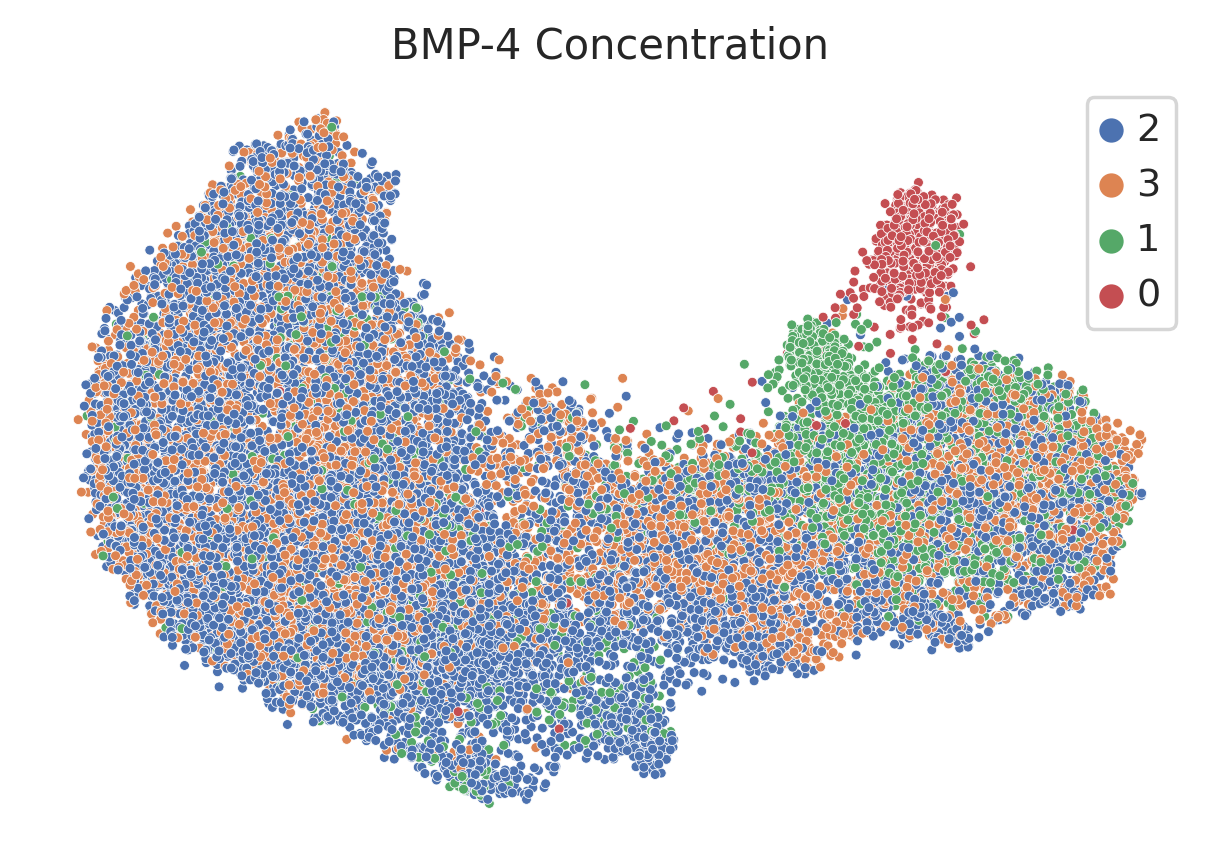

In [52]:
plt.figure(figsize=(6,4))
sns.scatterplot(x =adata.obsm['X_umap'][:,0], y =adata.obsm['X_umap'][:,1], s=8, hue=egf)
plt.title('BMP-4 Concentration')
plt.axis('off')
plt.grid(False)

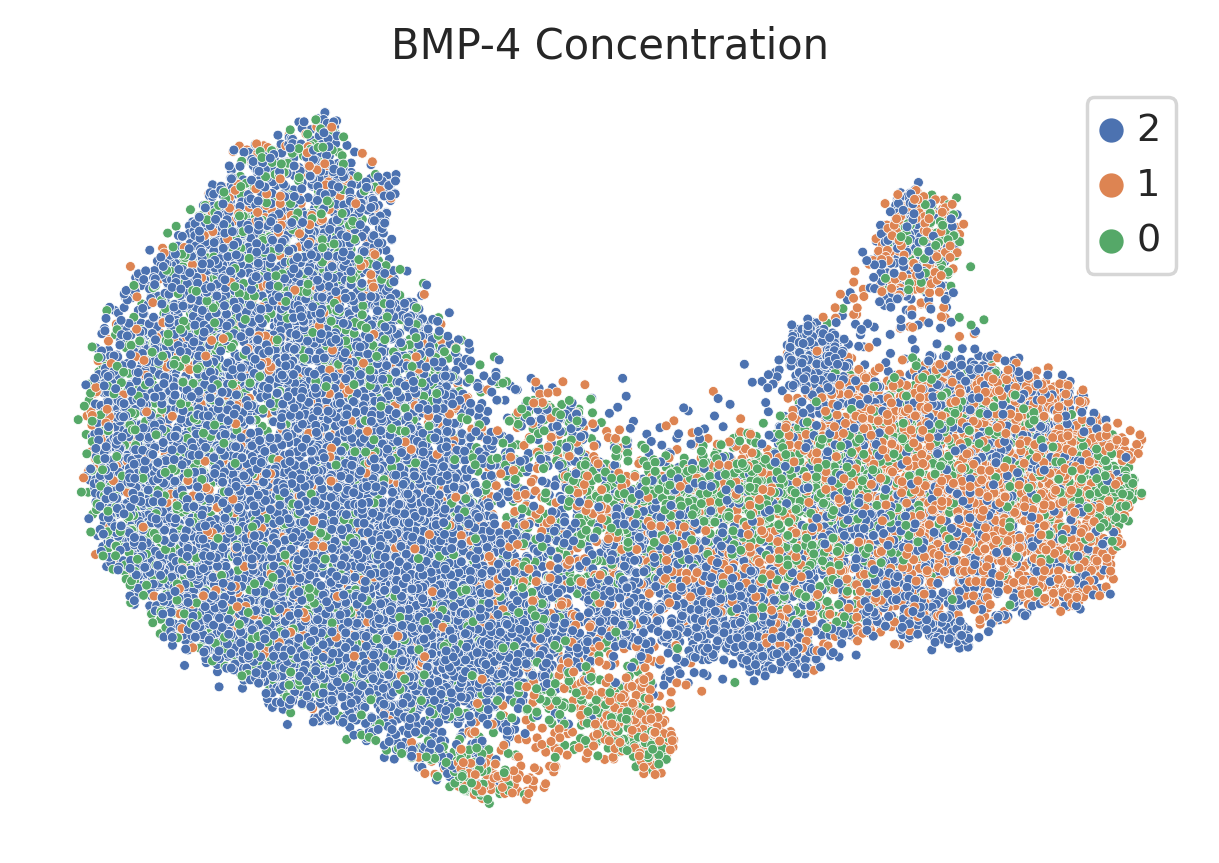

In [53]:
plt.figure(figsize=(6,4))
sns.scatterplot(x =adata.obsm['X_umap'][:,0], y =adata.obsm['X_umap'][:,1], s=8, hue=sd)
plt.title('BMP-4 Concentration')
plt.axis('off')
plt.grid(False)

### **Do L1 Distance Analysis in PCA Space for Perturbed Cells**

In [178]:
#Get X_PCA centroid  for wells with lowest in all treatments (no perturbation)
control_PCA = np.mean(adata[adata.obs['assignments'].isin(['95','83','94'])].obsm['X_pca'],axis=0)
control_PCA.shape

(50,)

In [179]:
#Get X_PCA centroid for wells with highest in BMP4, EGF, SD, RA but no other treatment
highBMP_PCA = np.mean(adata[adata.obs['assignments'].isin(['86','74'])].obsm['X_pca'],axis=0)
highEGF_PCA = np.mean(adata[adata.obs['assignments'].isin(['11','23'])].obsm['X_pca'],axis=0)
#highSD_PCA = np.mean(adata[adata.obs['assignments'].isin(['81'])].obsm['X_pca'],axis=0) too few cells




In [180]:
#Get X_PCA centroid  for wells with second lowest (beside no addition) in BMP4, EGF, SD, RA but no other treatment
lowBMP_PCA = np.mean(adata[adata.obs['assignments'].isin(['92','80'])].obsm['X_pca'],axis=0)
lowEGF_PCA = np.mean(adata[adata.obs['assignments'].isin(['59','71'])].obsm['X_pca'],axis=0)
#lowSD_PCA = np.mean(adata[adata.obs['assignments'].isin(['82'])].obsm['X_pca'],axis=0) too few cells



In [181]:
#Get X_PCA centroid  for wells with second highest in BMP4, EGF, SD, RA but no other treatment
midBMP_PCA = np.mean(adata[adata.obs['assignments'].isin(['77','89'])].obsm['X_pca'],axis=0)
midEGF_PCA = np.mean(adata[adata.obs['assignments'].isin(['35','47'])].obsm['X_pca'],axis=0)
#lowSD_PCA = np.mean(adata[adata.obs['assignments'].isin(['82'])].obsm['X_pca'],axis=0) too few cells



In [182]:
def doL1(cent1,cent2):
  return np.linalg.norm(cent1-cent2,1)

In [183]:
def doPairwise(cent1,cent2):
  d = pairwise_distances(cent1,cent2, metric = 'l1')
  return d.reshape((d.shape[0]*d.shape[1],))

In [184]:

labs = ['Control-High BMP4', 'Control-High EGF',
        'Low-High BMP4', 'Low-High EGF',
        'Mid-High BMP4', 'Mid-High EGF']

dists = [doL1(control_PCA,highBMP_PCA),doL1(control_PCA,highEGF_PCA),
         doL1(lowBMP_PCA,highBMP_PCA),doL1(lowEGF_PCA,highEGF_PCA),
         doL1(midBMP_PCA,highBMP_PCA),doL1(midEGF_PCA,highEGF_PCA)]

l1dists = pd.DataFrame()

l1dists['Condition'] = labs
l1dists['Perturbation'] = ['BMP4','EGF','BMP4','EGF','BMP4','EGF']
l1dists['Distance'] = dists


In [185]:
l1dists

Condition Perturbation   Distance
0  Control-High BMP4         BMP4  50.213768
1   Control-High EGF          EGF  45.273293
2      Low-High BMP4         BMP4  25.775112
3       Low-High EGF          EGF  37.925369
4      Mid-High BMP4         BMP4  34.411671
5       Mid-High EGF          EGF  21.955193

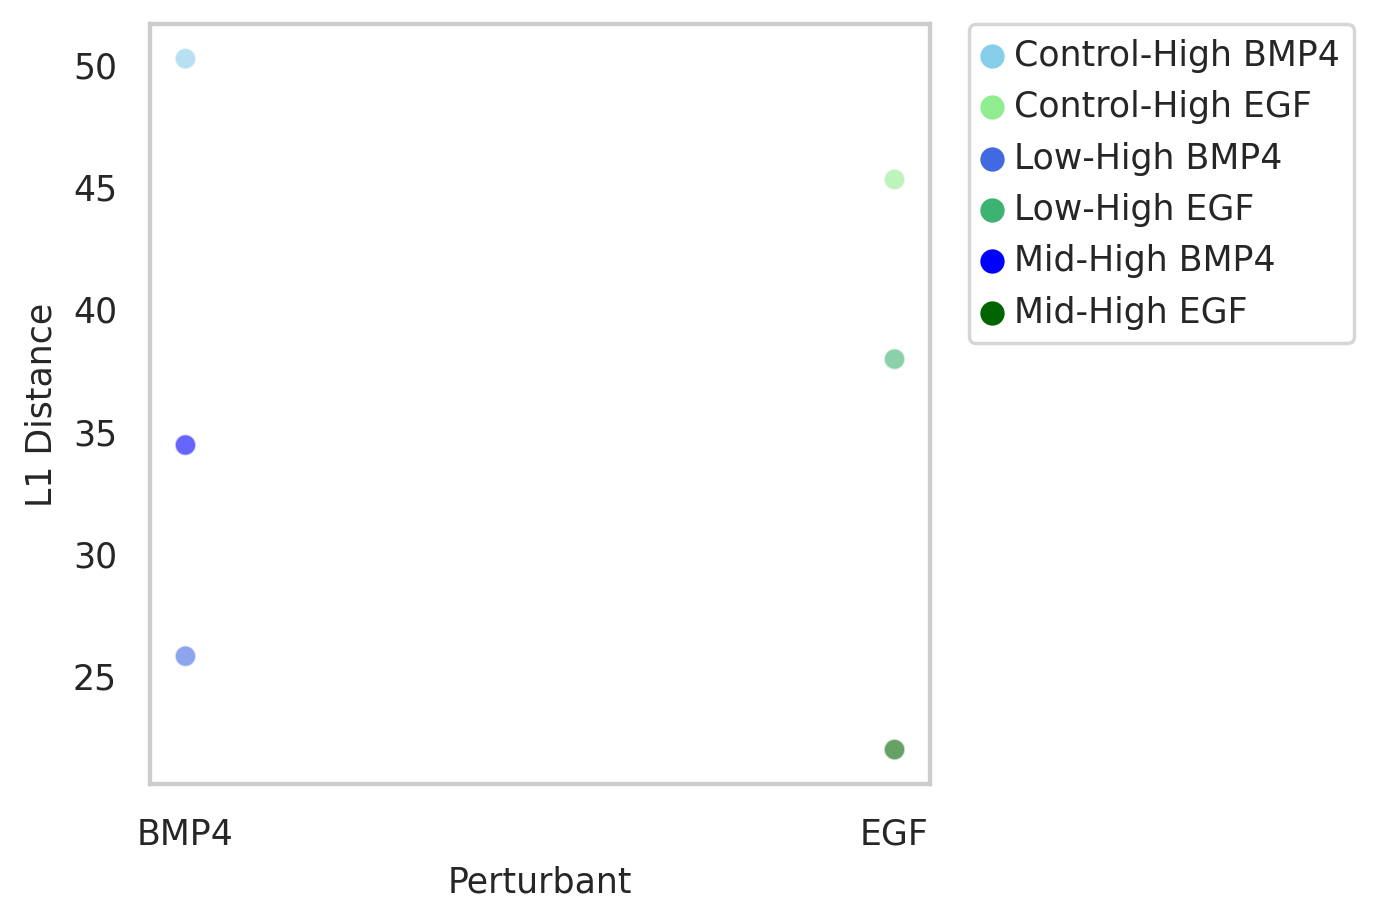

In [186]:
plt. grid(False)
sns.scatterplot(data=l1dists,x='Perturbation',y='Distance',hue='Condition',palette=['skyblue','lightgreen','royalblue','mediumseagreen','blue','darkgreen'],alpha=0.6)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.yticks(fontsize=10 )
plt.xticks(fontsize=10 )

plt.xlabel('Perturbant',fontsize=10)
plt.ylabel('L1 Distance',fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=10)
plt.show()



Show pairwise distance distributions between all cells

In [189]:
#Get X_PCA centroid  for wells with lowest in all treatments (no perturbation)
control_PCA = adata[adata.obs['assignments'].isin(['95','83','94'])].obsm['X_pca']
control_PCA.shape

(6, 50)

In [190]:
#Get X_PCA centroid for wells with highest in BMP4, EGF, SD, RA but no other treatment
highBMP_PCA = adata[adata.obs['assignments'].isin(['86','74'])].obsm['X_pca']
highEGF_PCA = adata[adata.obs['assignments'].isin(['11','23'])].obsm['X_pca']
#highSD_PCA = np.mean(adata[adata.obs['assignments'].isin(['81'])].obsm['X_pca'],axis=0) too few cells




In [191]:
#Get X_PCA centroid  for wells with second lowest (beside no addition) in BMP4, EGF, SD, RA but no other treatment
lowBMP_PCA = adata[adata.obs['assignments'].isin(['92','80'])].obsm['X_pca']
lowEGF_PCA = adata[adata.obs['assignments'].isin(['59','71'])].obsm['X_pca']
#lowSD_PCA = np.mean(adata[adata.obs['assignments'].isin(['82'])].obsm['X_pca'],axis=0) too few cells



In [192]:
#Get X_PCA centroid  for wells with second highest in BMP4, EGF, SD, RA but no other treatment
midBMP_PCA = adata[adata.obs['assignments'].isin(['77','89'])].obsm['X_pca']
midEGF_PCA = adata[adata.obs['assignments'].isin(['35','47'])].obsm['X_pca']
#lowSD_PCA = np.mean(adata[adata.obs['assignments'].isin(['82'])].obsm['X_pca'],axis=0) too few cells



In [193]:
labs = ['Control-High BMP4', 'Control-High EGF',
        'Low-High BMP4', 'Low-High EGF',
        'Mid-High BMP4', 'Mid-High EGF']

dists = [doPairwise(control_PCA,highBMP_PCA),doPairwise(control_PCA,highEGF_PCA),
         doPairwise(lowBMP_PCA,highBMP_PCA),doPairwise(lowEGF_PCA,highEGF_PCA),
         doPairwise(midBMP_PCA,highBMP_PCA),doPairwise(midEGF_PCA,highEGF_PCA)]

l1dists = pd.DataFrame()

l1dists['Condition'] = labs
l1dists['Perturbation'] = ['BMP4','EGF','BMP4','EGF','BMP4','EGF']
l1dists['Distance'] = dists


In [194]:
l1dists.head()

Condition  ...                                           Distance
0  Control-High BMP4  ...  [77.52898124419153, 72.17441816721112, 84.5034...
1   Control-High EGF  ...  [106.23994323634543, 118.66774046700448, 115.1...
2      Low-High BMP4  ...  [82.82179004047066, 81.43283366039395, 83.3728...
3       Low-High EGF  ...  [66.36589867505245, 75.29247417673469, 77.9861...
4      Mid-High BMP4  ...  [81.54343976732343, 93.21195327863097, 82.5935...

[5 rows x 3 columns]

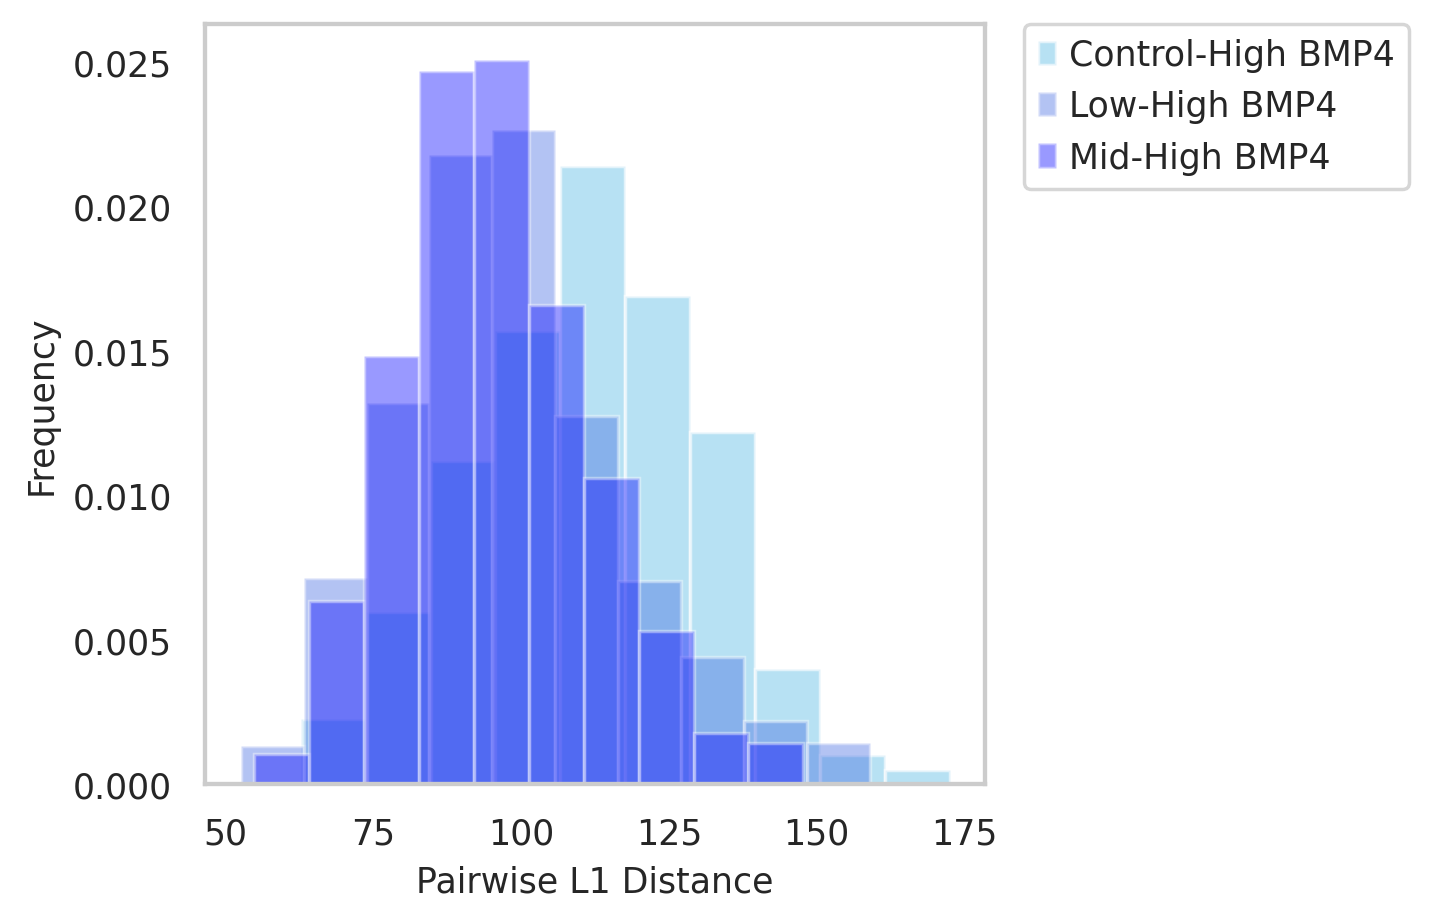

In [195]:
plt. grid(False)
plt.hist(l1dists[l1dists.Condition == 'Control-High BMP4'].Distance,color='skyblue',alpha=0.6,label ='Control-High BMP4' ,density=True)
plt.hist(l1dists[l1dists.Condition == 'Low-High BMP4'].Distance,color='royalblue',alpha=0.4,label = 'Low-High BMP4',density=True)
plt.hist(l1dists[l1dists.Condition == 'Mid-High BMP4'].Distance,color='blue',alpha=0.4,label = 'Mid-High BMP4',density=True)

plt.yticks(fontsize=10 )
plt.xticks(fontsize=10 )

plt.xlabel('Pairwise L1 Distance',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=10)
plt.show()
#sns.histplot(data=l1dists, x="sepal_width", color="red", label="Sepal Width")


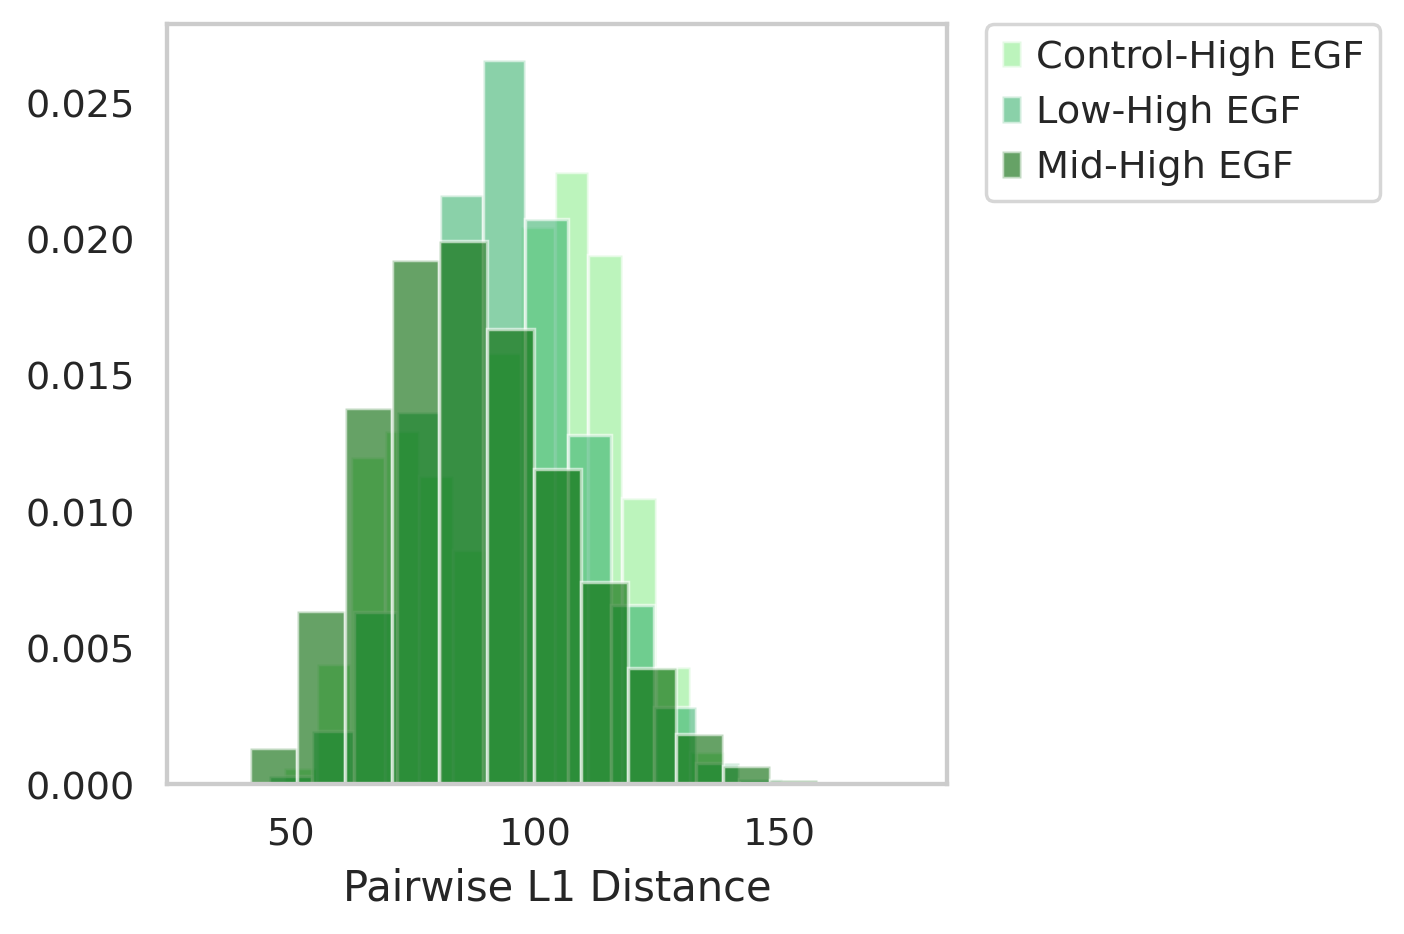

In [197]:
plt. grid(False)
plt.hist(l1dists[l1dists.Condition == 'Control-High EGF'].Distance,color='lightgreen',bins=15,alpha=0.6,label ='Control-High EGF' ,density=True)
plt.hist(l1dists[l1dists.Condition == 'Low-High EGF'].Distance,color='mediumseagreen',bins=15,alpha=0.6,label = 'Low-High EGF',density=True)
plt.hist(l1dists[l1dists.Condition == 'Mid-High EGF'].Distance,color='darkgreen',bins=15,alpha=0.6,label = 'Mid-High EGF',density=True)

plt.xlabel('Pairwise L1 Distance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()